In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import scipy.stats
import seaborn as sns
import numba

from numba.typed import List

from gnn_testbed.event_generation import (
    Detector,
    proposal_setup,
    generate_cascade,
    generate_realistic_track,
    make_line
)

from gnn_testbed.plotting import plot_events, plot_event
from gnn_testbed.feature_generation import get_features
from gnn_testbed.event_generation.photon_propagation import BiolumiSource, generate_biolumi_photons, dejit_biolumi_sources
from gnn_testbed.event_generation.mc_record import MCRecord
from gnn_testbed.event_generation import proposal_setup
prop = proposal_setup()

In [2]:
dfs = pd.read_pickle("statistics_seed_0.p")

Text(0, 0.5, '# Emitters')

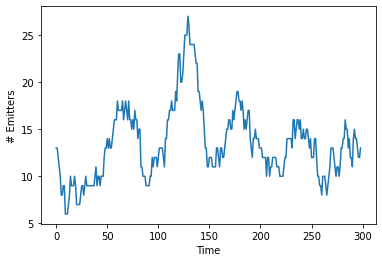

In [3]:
plt.plot([(df["photons"] > 10).sum() for df in dfs])
plt.xlabel("Time")
plt.ylabel("# Emitters")

[]

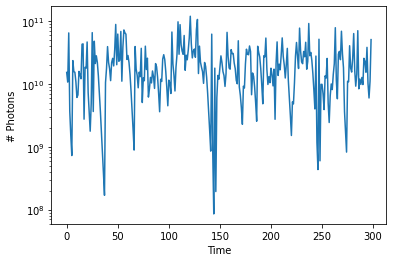

In [4]:

n_photons_per_sec = [df["photons"].sum() for df in dfs]

plt.plot(n_photons_per_sec)
plt.xlabel("Time")
plt.ylabel("# Photons")
plt.semilogy()

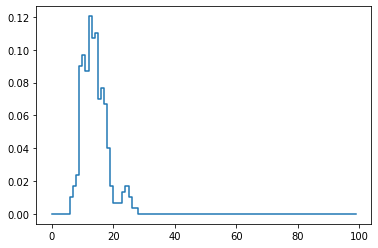

In [5]:
n_em_prob, edges = np.histogram([(df["photons"] > 10).sum() for df in dfs], bins=np.arange(100))
n_em_prob = n_em_prob / n_em_prob.sum()
plt.step(edges, np.append(n_em_prob, n_em_prob[-1]), where="post")

In [21]:
rng = np.random.RandomState(31338)
oms_per_line = 50
dist_z = 20
modules = make_line(0, 0, dist_z, oms_per_line, rng, 1e-6, 0)
modules += make_line(150, 0, dist_z, oms_per_line, rng, 1e-6, 0)
modules += make_line(75, 130, dist_z, oms_per_line, rng, 1e-6, 0)
det = Detector(modules)

In [22]:
lc_map = {}
for mod in det.modules[:10]:
    line_id, mod_id = mod.key
    lc_links = [
        (line_id, i) for i in range(max(0, mod_id-2), min(oms_per_line, mod_id+3))
        if i != mod_id
    ]
    lc_map[mod.key] = lc_links


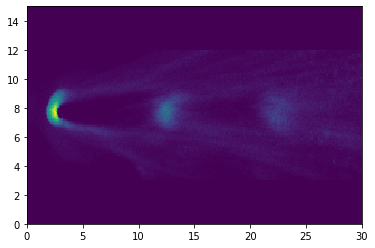

In [23]:
prob_model = pd.read_pickle("prob_model.p")
# fix artifacts
prob_model[2][:30, :] = 0
prob_model[2][120:, :] = 0
plt.pcolormesh(prob_model[0], prob_model[1], prob_model[2])

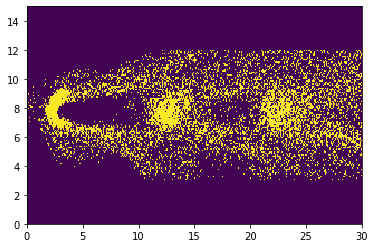

In [24]:
weights = prob_model[2].ravel()
weights /= weights.sum()


ix = np.random.choice(np.arange(len(weights)), p=weights, replace=True, size=10000)
a, b = np.unravel_index(ix, shape=prob_model[2].shape)

samples = np.zeros_like(prob_model[2])
samples[a, b] += 1
plt.pcolormesh(prob_model[0], prob_model[1], samples)

In [25]:
det_pos = [3, 7.35]
n_photons = 20E4
t0 = 0
t_spread = 1E4

pcath_area = 16 * (7.62/2)**2 * np.pi * 1E-4
source_list = []

rng = np.random.RandomState(1)



for mod in modules:
    
    sim_ix = rng.randint(0, len(dfs))
    
    bio_sim = dfs[sim_ix]
    
    n_ems = (bio_sim["photons"] > 10).sum()
    n_photons = bio_sim.loc[bio_sim["photons"] > 10, "photons"].values / 1E9 * t_spread
    
    #n_ems = rng.choice(np.arange(len(n_em_prob)), p=n_em_prob, replace=True)
    
    #n_photons = rng.choice(n_photons_per_sec) / 1E9 * t_spread / n_ems
    
    if n_ems == 0:
        continue
        
    ix = rng.choice(np.arange(len(weights)), p=weights, replace=True, size=n_ems)
    ixy, ixx = np.unravel_index(ix, shape=prob_model[2].shape)
    
    pos_x = prob_model[0][ixx] - det_pos[0] + mod.pos[0]
    pos_y = prob_model[1][ixy] - det_pos[1] + mod.pos[1]
    
    for px, py, nph in zip(pos_x, pos_y, n_photons):
        pos = np.asarray([px, py, mod.pos[2]+np.random.normal(0.1, 1)])
    
        source = BiolumiSource(pos, nph, t0, t_spread)
        source_list.append(source)

rec_lumi = MCRecord(
    "biolumi", dejit_biolumi_sources(source_list), {"n_photons": n_photons, "spread": t_spread}
)
hit_times_biolumi = ak.sort(
    ak.Array(
        generate_biolumi_photons(
            det.module_coords, det.module_efficiencies, List(source_list), seed=1,
            lambda_abs=30, lambda_sca = 100,
            photocathode_area = pcath_area
        )
    )
)



In [26]:
#@numba.jit(nopython=True)
def coinc(hit_times):
    res = []
    for ts in hit_times:
        trig = np.any((ts[1:] - ts[:-1]) < 1E3)
        if trig:
            res.append(ts)
        else:
            res.append([])
    return ak.Array(res)

#def local_coinc(hit_times):

#def trigger(hit_times):
hit_times_coinc = coinc(hit_times_biolumi)


Text(0.5, 0, 'Time [ns]')

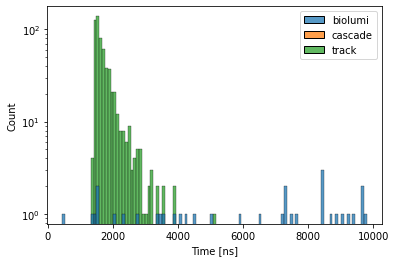

In [27]:
p = np.asarray([100., 100., 0.])

hit_times_casc, rec_casc = generate_cascade(det, p, 0, energy=1E4,
                                       lambda_abs=30, lambda_sca = 100,
                                       photocathode_area = pcath_area)
p = np.asarray([200., 200., 200])
d = np.asarray([-1., -1., -1.5])
d /= np.linalg.norm(d)


hit_times_track, rec_track = generate_realistic_track(det, p, d, 1000, 3E5, propagator=prop,
                                                lambda_abs=30, lambda_sca = 100,
                                                photocathode_area = pcath_area
                                               )
#hit_times_coinc = coinc(hit_times)

#max_ix = ak.argmax(ak.count(hit_times_biolumi, axis=1))

max_ix = 8
hist_data = {
    "biolumi": np.asarray(hit_times_biolumi[max_ix]),
    "cascade": np.asarray(hit_times_casc[max_ix]),
    "track": np.asarray(hit_times_track[max_ix])
}

sns.histplot(hist_data)
plt.semilogy()
#plt.xlim(0, 3000)
plt.xlabel("Time [ns]")


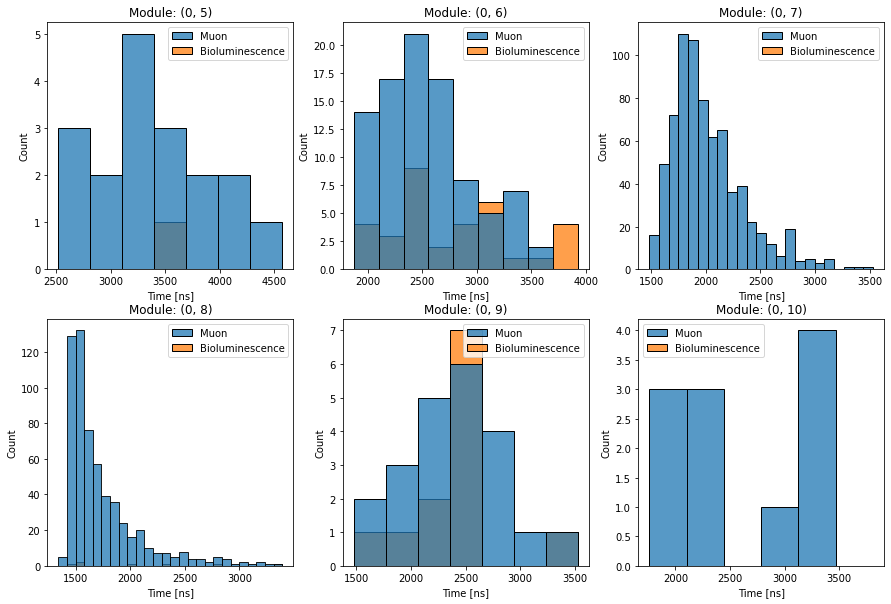

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(3*5, 2*5))

mask = ak.count(hit_times_track, axis=1) > 5

sel_track = hit_times_track[mask]
sel_bio = hit_times_biolumi[mask]
mod_keys = np.argwhere(np.asarray(mask)).ravel()

for i, ax in zip(range(len(sel_track)), axs.ravel()):
    plot_data = {
        "Muon": np.asarray(sel_track[i]),
        "Bioluminescence": np.asarray(sel_bio[i])
    }
    sns.histplot(plot_data, ax=ax, binrange=[ak.min(sel_track[i])-50, ak.min(sel_track[i])+2000])
    ax.set_xlabel("Time [ns]")
    ax.set_title(f"Module: {modules[mod_keys[i]].key}")
plt.savefig("photoncounts_track_biolumi.pdf")

In [29]:
ak.argmax(ak.count(hit_times_track, axis=1))

7

In [30]:
class SPETemplate:
    def __init__(self):
        self.components = [
            scipy.stats.expon(scale=1),
            scipy.stats.truncnorm(-1/0.3, 10, loc=1, scale=0.3)
        ]
        
        self.weights = [0.3, 0.7]
        
    def rvs(self, size):
        pe = np.ones(size)*(-1.)
        comp = np.random.choice([0, 1], p=self.weights, size=size)
    
        is_comp_0 = comp==0   
        pe[is_comp_0] = self.components[0].rvs(size=is_comp_0.sum())

        is_comp_1 = comp==1
        pe[is_comp_1] = self.components[1].rvs(size=is_comp_1.sum())
        return pe
        
        
    
def make_waveform(hits, template, times=None):
    #jitter = scipy.stats.norm(0, 2, size=len(hits))
    #times = hits + jitter.rvs(size=len(hits))
    
    charges = template.rvs(len(hits))
    
    if times is None:
        tmin = hits[0] - 6
        tmax = hits[-1] + 6

        times = np.arange(tmin, tmax, 2)
        
    wv = (charges[np.newaxis, :] * scipy.stats.gumbel_r.pdf(times[:, np.newaxis], loc=hits+2, scale=2)).sum(axis=1)

    return wv, times
    
    
template = SPETemplate()


/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3252: RuntimeWarning:

overflow encountered in exp



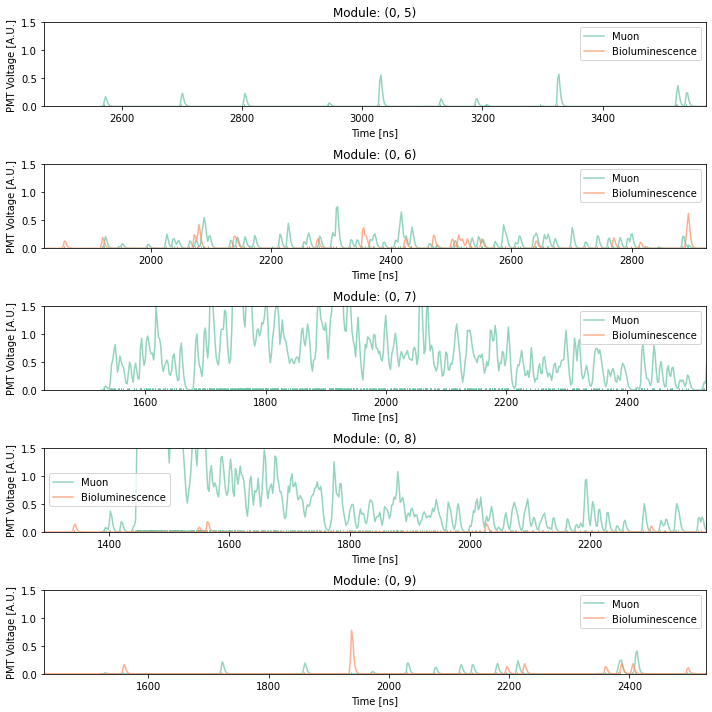

In [31]:
fig, axs = plt.subplots(5, figsize=(10, 5*2))
mask = ak.count(hit_times_track, axis=1) > 5

sel_track = hit_times_track[mask]
sel_bio = hit_times_biolumi[mask]

mod_keys = np.argwhere(np.asarray(mask)).ravel()

colors = sns.color_palette("Set2")
for i, ax in zip(range(len(sel_track)), axs.ravel()):

    if len(sel_track[i]) > 0:
        wv_track, ttrack = make_waveform(sel_track[i], template)
        ax.plot(ttrack, wv_track, alpha=0.7, label="Muon", color=colors[0])
        sns.rugplot(x=sel_track[i], color=colors[0], ax=ax)
    
    if len(sel_bio[i]) > 0:
        wv_lumi, tlumi = make_waveform(sel_bio[i], template)
        ax.plot(tlumi, wv_lumi, alpha=0.7, label="Bioluminescence", color=colors[1])
        sns.rugplot(x=sel_bio[i], color=colors[1], ax=ax)
    #figure = plt.figure(figsize=(15, 5))

    
    ax.set_ylim(0, 1.5)
    
    ax.legend()
    ax.set_xlabel("Time [ns]")
    ax.set_ylabel("PMT Voltage [A.U.]")
    ax.set_xlim(ak.min(sel_track[i])-100, ak.min(sel_track[i])+1000)
    ax.set_title(f"Module: {modules[mod_keys[i]].key}")
plt.tight_layout()
plt.savefig("waveforms_track_biolumi.pdf")

In [32]:
tw = [ak.min(hit_times_track), ak.max(hit_times_track)]

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning:

divide by zero encountered in log10



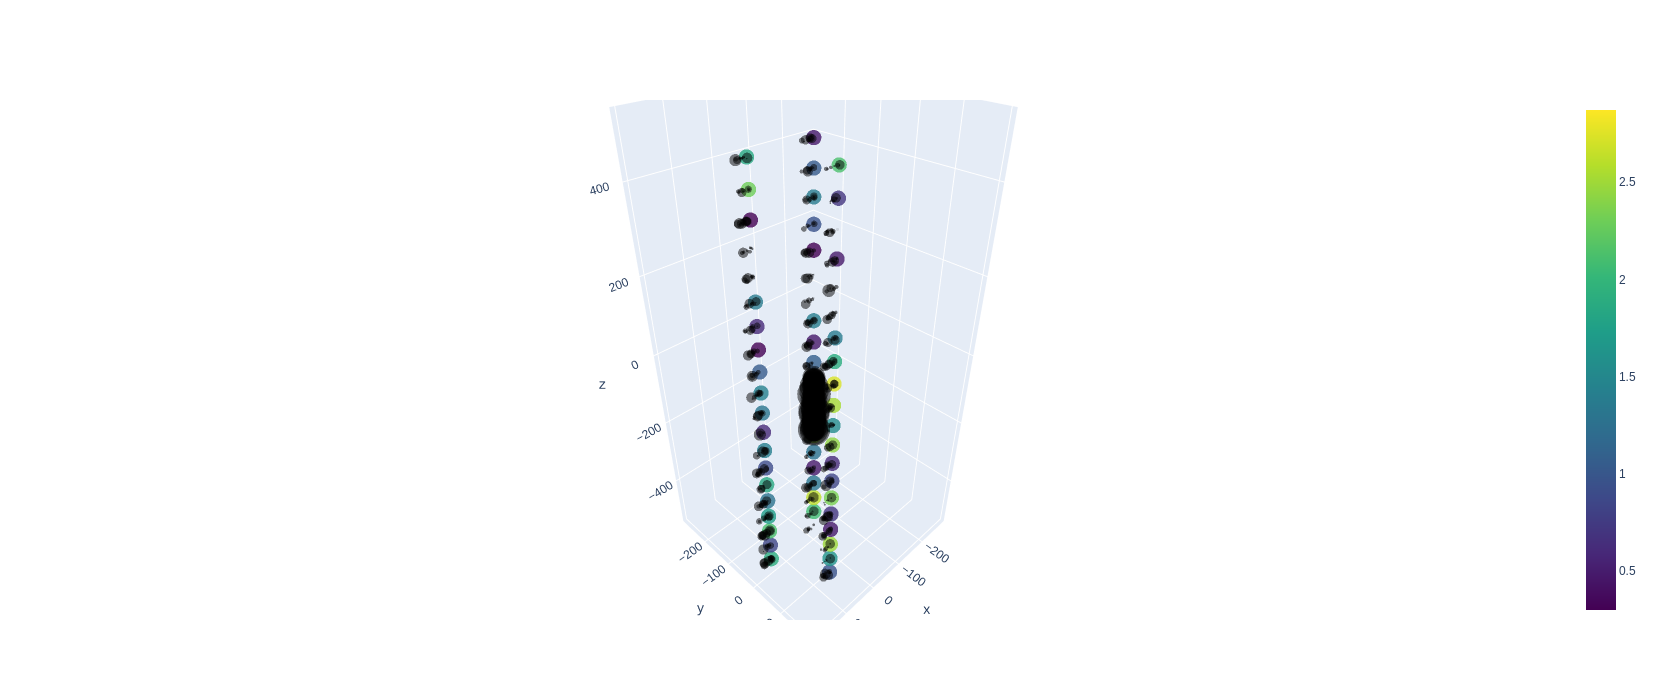

In [33]:

hit_times = ak.sort(ak.concatenate([hit_times_track, hit_times_biolumi], axis=1))

sel_window = hit_times_track >tw[0]

hit_times_sel = hit_times[ (hit_times_track >tw[0]) & (hit_times_track <tw[1])]
rec = rec_lumi + rec_track
fig = plot_event(det, hit_times, record=rec)
fig.write_html("biolumi_plus_muon.html")

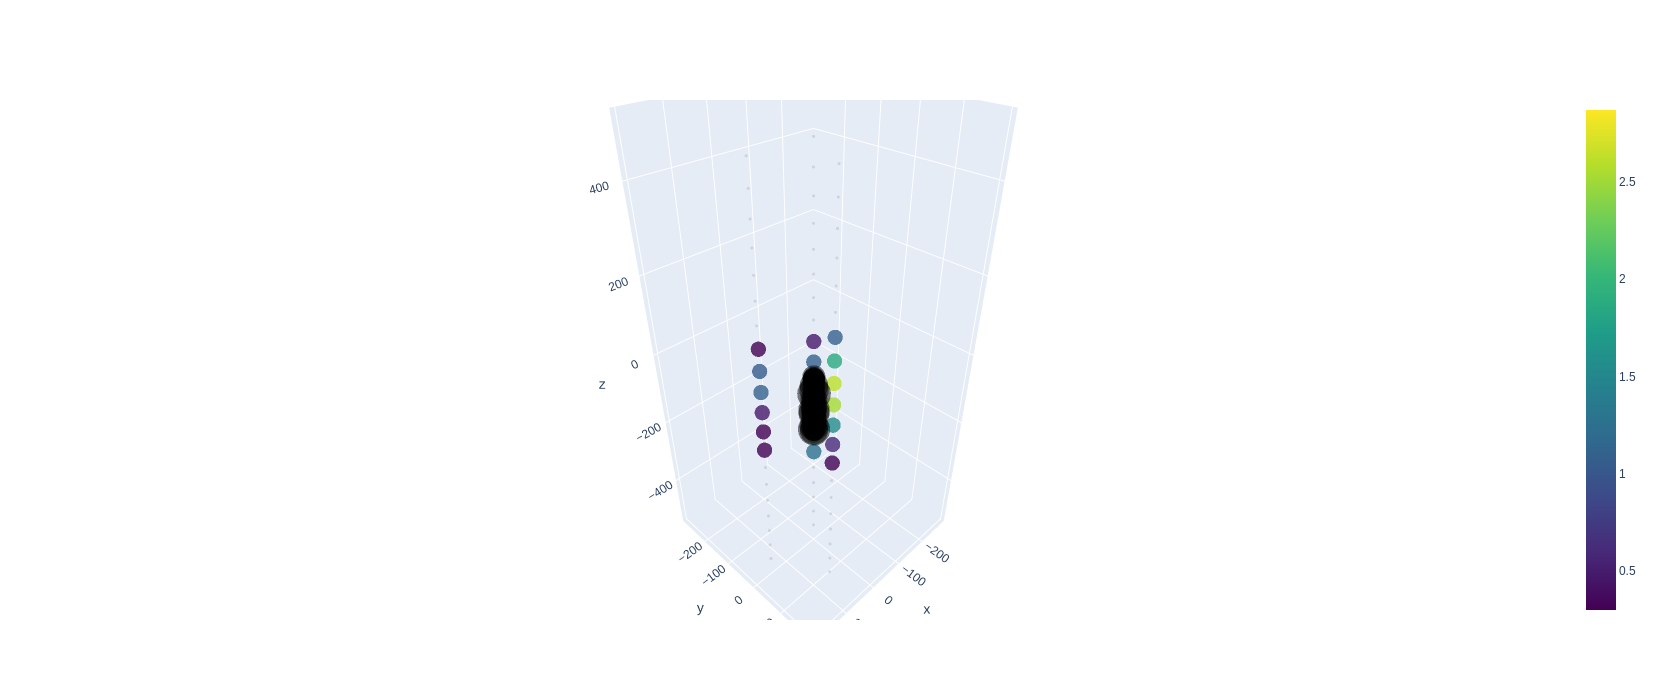

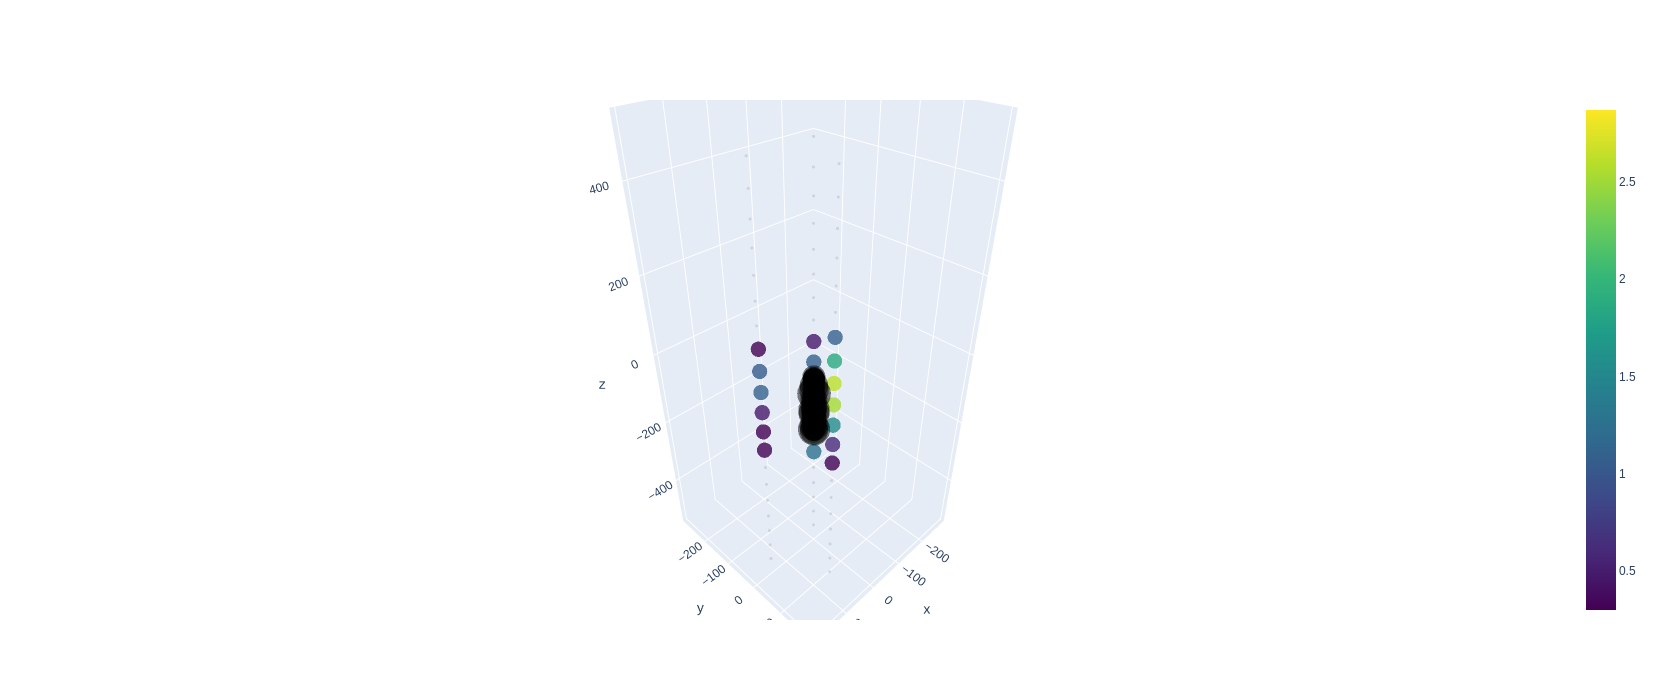

In [34]:
plot_event(det, hit_times_track, record=rec_track)

<AxesSubplot:ylabel='Count'>

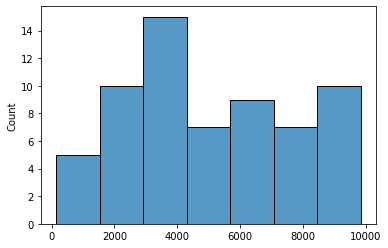

In [20]:
sns.histplot(np.asarray(hit_times[ak.count(hit_times, axis=1) > 0][0]))

In [ ]:
plot_event(det, hit_times)

In [ ]:
sns.histplot(np.asarray(event[20]))

In [ ]:
np.asarray(event[1]).min()- np.asarray(event[1]).max()


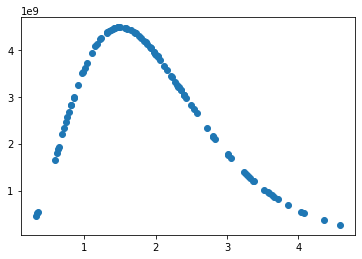

In [69]:
plt.plot(times, amps, "o")